# How Do We Learn the Wave Equation?

In [1]:
import sys
if True: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/omega/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/omega/")
else: # Local
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip3 install cmocean
!pip3 install git+https://github.com/rtqichen/torchdiffeq
!pip3 install detest

     |████████████████████████████████| 225kB 5.0MB/s 
  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-w0xkc5ji
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-w0xkc5ji
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25885 sha256=f942a009616b848de607a6ba07496238bd34c86788bb7a2bd8074c5da5fb7795
  Stored in directory: /tmp/pip-ephem-wheel-cache-714j5u_3/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


In [0]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.animation as animation
import cmocean, seaborn

In [0]:
import plotly
import plotly.graph_objects as go

In [0]:
import utils, plotting, helper, models, ode_helper, \
        analytical_solutions
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)
importlib.reload(ode_helper)
importlib.reload(analytical_solutions)

from helper import *
from utils import *
from analytical_solutions import *
from ode_helper import *

In [6]:
device=get_device()
set_seed()

Connected to a GPU


We can generate any dataset that we want with the analytical solution.

In [7]:
ts, data = make_wave_dataset(10, 500, t_max=20,
                             params=WAVE_PARAMS[1])
torch_data = data_to_torch(data, device=device)
torch_ts = data_to_torch(ts, device=device)
NT,_,NX = data.shape
dt = ts[1]-ts[0]
print(dt)

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]
0.04008016032064128


We want to learn the true operator, and we'll try multiple strategies to do so:
1. Optimize Omega and take the matrix log
2. Add an elastic net to Omega, and take the matrix log
3. Learn a model in an ODE solver, and hope the model is Lambda
4. Use the mixed ODE-loss, and hypothesize that prevents overfitting.

In [0]:
class Experiment():
    """
    This is an awkward container class to store experiment
    results in this notebook.
    """
    def __init__(self, learning_rate=None,gamma_L1=0,gamma_L2=0, batch_size=100, ode=False,methods=('euler',)):
        self.ode = ode
        self.methods=methods
        self.gamma_L1 = gamma_L1
        self.gamma_L2 = gamma_L2
        self.batch_size = batch_size
        if ode:
            self.learning_rate = 1.0e-2 if learning_rate is None else learning_rate
            self.model = models.MultiLinearODE((2,NX),(2,NX),bias=False).double().to(device)
        else:
            self.learning_rate = 5.0e-4 if learning_rate is None else learning_rate
            self.model = models.MultiLinear((2,NX),(2,NX),bias=False).double().to(device)
        # This is the awkard state
        self.losses = np.array([])
        self.callback = lambda m,o,l, do_it=False : self._callback(m,o,l, do_it=do_it)
        self.save_schedule = [2.0**-i for i in range(-1,100)]
        self.next_save = self.save_schedule.pop(0)
        self.weight_dump = []
        self.all_metrics = []
        
    def name(self):
        return f"""{"ode_"+"".join([s[0] for s in self.methods]) if self.ode else "mat"}_{self.gamma_L1:1.1e}_{self.gamma_L2:1.1e}"""

    def _callback(self, model, opt_iter, loss, do_it=False):
        if do_it or loss < self.next_save:
            Om = self.model.net.weight.detach().cpu().numpy().copy()
            self.weight_dump.append(Om)
            self.all_metrics.append((opt_iter,loss))
            print("Saving at ",opt_iter, " with loss ",loss)
            self.next_save = self.save_schedule.pop(0)
            
    def train(self,N_iter=10000):
        N_left = N_iter - len(self.losses)
        print(len(self.losses))
        if N_left <= 0: return
        if not self.ode:
            _,losses = learn_rnn(torch_data, self.model,
                N_iter=N_left, batch_size= self.batch_size,
                N_print=100, callback=self.callback,
                learning_rate=self.learning_rate, gamma_L1=self.gamma_L1, gamma_L2=self.gamma_L2,
                device=device)
        else:
            _,losses = train_a_neural_ode_multi_method(torch_data, torch_ts,
                self.model,
                N_iter=N_left, batch_size=self.batch_size,
                learning_rate=self.learning_rate, gamma_L1=self.gamma_L1, gamma_L2=self.gamma_L2,
                methods=self.methods,
                N_print=100,callback=self.callback,
                device=device)
        self.losses = np.append(self.losses,losses)
        
    def post(self):
        if not self.ode:
            self.all_omegas = self.weight_dump.copy()
            self.np_omegas = np.array(self.all_omegas)
            self.UVs = [helper.integrate_matrix(self.np_omegas[i,:,:],
                                    torch_data[0:1,:,:].cpu().numpy(), 25 )
                        for i in range(self.np_omegas.shape[0]) ]
            self.all_lambdas = [ lambda_of_omega(om,dt) 
                                for om in self.all_omegas ]
            self.np_lambdas = np.array(self.all_lambdas)
        else:
            self.all_lambdas = self.weight_dump.copy()
            self.np_lambdas = np.array(self.all_lambdas)
            self.all_omegas = [operator_factory(L, dt,method=self.methods[-1]) for L in self.all_lambdas]
            self.np_omegas = np.array(self.all_omegas)

    def make_animation(self,interval=1,transpose=False):
        img = self.np_omegas
        metrics = self.all_metrics
        UVs = self.UVs
        fig, ax = plt.subplots(figsize=(6,3))
        minmax = np.max(np.abs(img)) * 0.65
        tr = lambda x : x.T if transpose else x
        ax_left = plt.subplot(1,2,1)
        ax_left.set_title(f"Iteration #{metrics[0][0]}     Loss = {metrics[0][1]:1.2e}")
        canvas = plt.imshow(tr(img[0,:,:]), interpolation='none',
                            cmap=cmocean.cm.balance, 
                            #interpolation='bicubic', 
                            vmin=-minmax, vmax=minmax)
        plt.axis('off')
        plt.text(-3,5,'$\\frac{du}{dt}$',fontsize=16)
        plt.text(-3,15,'$\\frac{dv}{dt}$',fontsize=16)
        plt.text(5,21,'$u$')
        plt.text(15,21,'$v$')
        ax = plt.subplot(1,2,2)
        ax.set_ylim((-0.5, 0.5))
        ax.set_title("$u(x,t)$")
        xs = np.linspace(0,1,UVs[0].shape[-1])
        line, = ax.plot(xs,UVs[0][0,0,:], lw=2)
        plt.tight_layout()
        def animate(i):
            frame = i//UVs[0].shape[0]
            time = i%UVs[0].shape[0]
            ax_left.set_title(f"Iteration #{metrics[frame][0]}     Loss = {metrics[frame][1]:1.2e}")
            line.set_data(xs,UVs[frame][time,0,:])
            canvas.set_array(tr(img[frame,:,:]))
            return canvas,
        ani = animation.FuncAnimation(fig, animate, frames=img.shape[0]*UVs[0].shape[0],
                                      interval = interval)
        return ani

In [0]:
stash = {}

In [10]:
experiments = [
    dict(),
    dict(gamma_L1 = 0, gamma_L2 = 1.0e-7),
    dict(gamma_L1 = 0, gamma_L2 = 1.0e-5),
    dict(gamma_L1 = 1.0e-5, gamma_L2 = 0.0),
    dict(gamma_L1 = 1.0e-4, gamma_L2 = 1.0e-7),
    dict(gamma_L1 = 1.0e-4, gamma_L2 = 1.0e-8),
    dict(gamma_L1 = 1.0e-5, gamma_L2 = 1.0e-7),
]
[
    dict(ode=True,methods=('euler',)),
    dict(ode=True,methods=('midpoint',)),
    dict(ode=True,methods=('rk4',)),
    dict(ode=True,
                methods=('euler','midpoint','rk4')),
    dict(ode=True,
                methods=('euler','midpoint','rk4'),
                gamma_L1 = 1.0e-5, gamma_L2 = 1.0e-7),
    dict(ode=True,
                methods=('euler','midpoint','rk4'),
                gamma_L1 = 0, gamma_L2 = 1.0e-7),
    dict(ode=True,
                methods=('euler','midpoint','rk4'),
                gamma_L1 = 1.0e-6, gamma_L2 = 0),
    dict(ode=True,methods=('midpoint','rk4')),
]

[{'methods': ('euler',), 'ode': True},
 {'methods': ('midpoint',), 'ode': True},
 {'methods': ('rk4',), 'ode': True},
 {'methods': ('euler', 'midpoint', 'rk4'), 'ode': True},
 {'gamma_L1': 1e-05,
  'gamma_L2': 1e-07,
  'methods': ('euler', 'midpoint', 'rk4'),
  'ode': True},
 {'gamma_L1': 0,
  'gamma_L2': 1e-07,
  'methods': ('euler', 'midpoint', 'rk4'),
  'ode': True},
 {'gamma_L1': 1e-06,
  'gamma_L2': 0,
  'methods': ('euler', 'midpoint', 'rk4'),
  'ode': True},
 {'methods': ('midpoint', 'rk4'), 'ode': True}]

In [0]:
for exp in stash.values():
    if exp.ode==True:
        exp.learning_rate = 1.0e-1
    else:
        exp.learning_rate = 1.0e-3
    exp.batch_size=200

In [12]:
N_iter = 15000
for exp in experiments:
    try:
        exp_obj = stash[tuple(exp.items())]
    except:
        exp_obj = Experiment(**exp)
        stash[tuple(exp.items())] = exp_obj
    exp_obj.train(N_iter=N_iter)

0
Saving at  99  with loss  0.11193096403128568
Saving at  199  with loss  0.045477307919848914
Saving at  299  with loss  0.022260652040972304
Saving at  399  with loss  0.010232515025335278
Saving at  499  with loss  0.005839826983493181
Saving at  599  with loss  0.003956135289312502
Saving at  699  with loss  0.0031464041025669447
Saving at  799  with loss  0.0026599763974844066
Saving at  899  with loss  0.0026113839497141408
Saving at  999  with loss  0.002650579015117934
Saving at  1499  with loss  0.0018916018581558944
Saving at  2499  with loss  0.0009211822900991655
Saving at  3199  with loss  0.00047540284324146687
Saving at  4099  with loss  0.00024287493285066585
Saving at  5599  with loss  0.00011604804351213077
Saving at  7299  with loss  5.964712653590621e-05
Saving at  9499  with loss  2.978907605127082e-05
Saving at  11799  with loss  1.5144776813037067e-05
Saving at  14999  with loss  8.169358906322392e-06
0
Saving at  99  with loss  0.18141161699778874
Saving at  19

/content/drive/My Drive/Colab Notebooks/omega/utils.py:10: ComplexWarning:

Casting complex values to real discards the imaginary part

/content/drive/My Drive/Colab Notebooks/omega/utils.py:9: RuntimeWarning:

divide by zero encountered in log

/content/drive/My Drive/Colab Notebooks/omega/utils.py:9: RuntimeWarning:

invalid value encountered in matmul



zero-size array to reduction operation minimum which has no identity
Skipping  mat_0.0e+00_1.0e-05


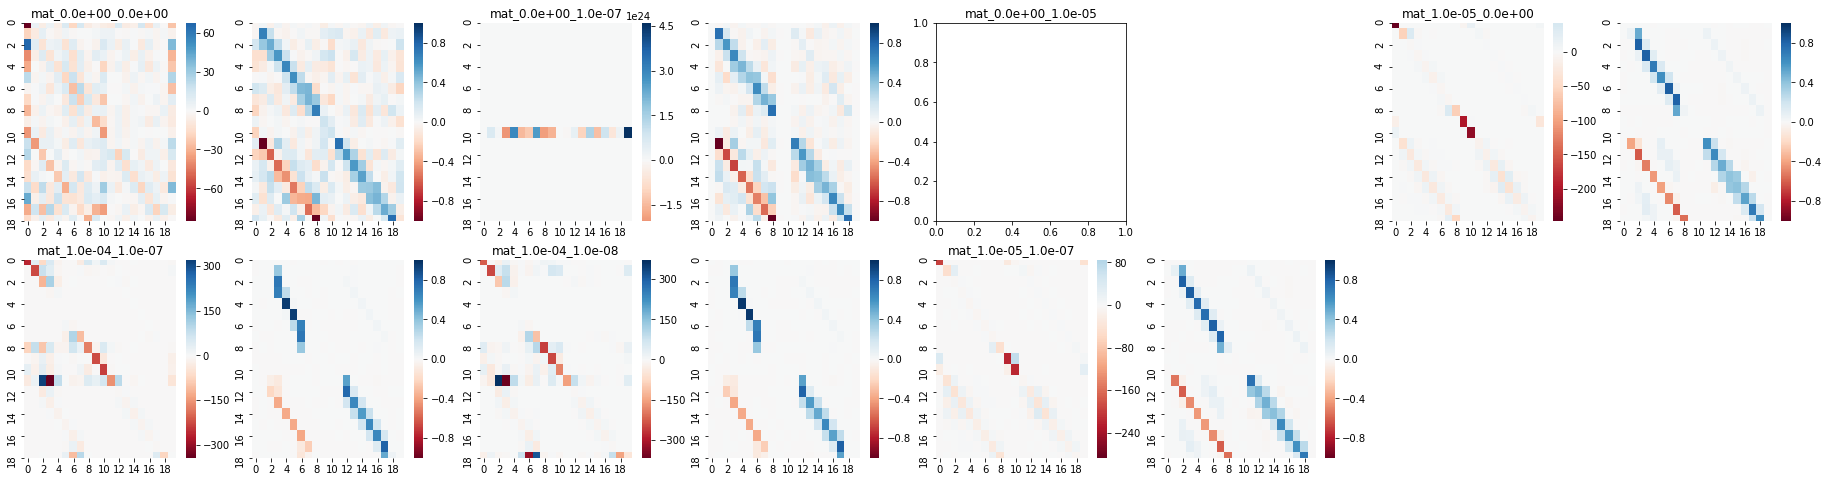

In [13]:
sp_y,sp_x = int(len(experiments)/4+0.5), 2*4
plt.figure(figsize=(4*sp_x,4*sp_y))
for i,exp in enumerate(stash.values()):
    try:
        exp.post()
        plt.subplot(sp_y,sp_x,2*i+1)
        plt.title(exp.name())
        seaborn.heatmap(exp.all_lambdas[-1], cmap='RdBu', center=0)
        plt.subplot(sp_y,sp_x,2*i+2)
        seaborn.heatmap(exp.all_omegas[-1], cmap='RdBu', center=0, vmin=-1,vmax=1)
    except Exception as e:
        print(e)
        print("Skipping ",exp.name())
plt.show()

In [0]:
exp=list(stash.values())[2]

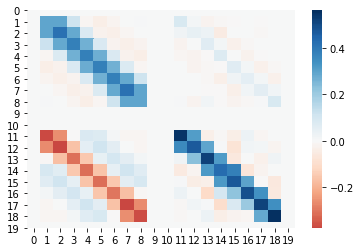

In [0]:
seaborn.heatmap(exp.all_omegas[-1],center=0, cmap='RdBu')

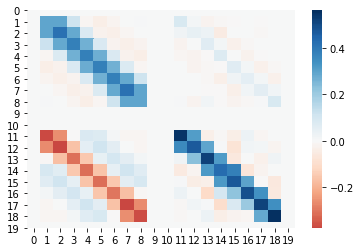

In [0]:
Om2 = exp.all_omegas[-1].copy()
ii=np.abs(Om2.sum(axis=0)) < 1.0e-15
Om2[ii,ii]=1.0e-10
seaborn.heatmap(Om2,center=0, cmap='RdBu')

/content/drive/My Drive/Colab Notebooks/omega/utils.py:10: ComplexWarning:

Casting complex values to real discards the imaginary part



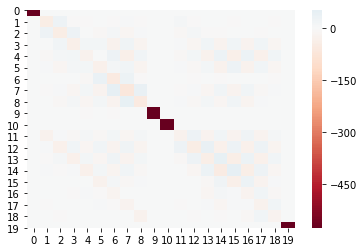

In [0]:
Lm2 = lambda_of_omega(Om2,dt)
seaborn.heatmap(Lm2,center=0, cmap='RdBu')

In [0]:
def mylambda(Om):
    w,V = np.linalg.eig(Om)
    logw = np.log(w)
    for i,a in enumerate(w):
        #if i>2: logw[i]=0.0
        if np.abs(a) <= 1e-12:
            print("setting",i)
            logw[i]=0.0
    #L = V @ np.diag(logw)/dt @ np.linalg.inv(V)
    L = V @ np.diag(logw)/dt @ V.T
    seaborn.heatmap(np.real(L),center=0, cmap='RdBu',vmin=-100,vmax=100)

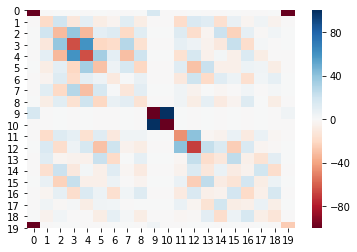

In [0]:
mylambda(Om2)

In [0]:
data = []
for exp in stash.values():
    try:
        data.append(go.Scatter(y=exp.losses,name=exp.name()))
    except:
        print("Skipping ",n)
go.Figure(data=data,layout=dict(yaxis_type="log") )

Output hidden; open in https://colab.research.google.com to view.

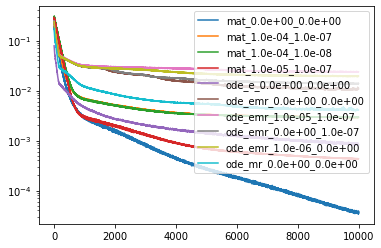

In [0]:
for exp in experiments:
    try:
        plt.semilogy(exp.losses,'-',label=exp.name())
    except:
        print("Skipping ",n)
plt.legend()

## Hyperparamter test:

It turns out that the ODE methods need learning rates with a different tuning.

In [0]:
LR_HYPER = { k:Experiment(ode=True) for k in [1.0e-2,1.0e-3,5.0e-4,1.0e-4,5.0e-5]}
for k,exp in LR_HYPER.items():
    exp.train_ode(N_iter=N_iter,learning_rate=k)

Saving at  4999  with loss  0.0033781249080902555
Saving at  4999  with loss  0.0033781249080902555
Saving at  4999  with loss  0.008240142868344312
Saving at  4999  with loss  0.008240142868344312
Saving at  4999  with loss  0.011062169444927545
Saving at  4999  with loss  0.011062169444927545
Saving at  4999  with loss  0.038727107219752685
Saving at  4999  with loss  0.038727107219752685
Saving at  4999  with loss  0.05020319540402678
Saving at  4999  with loss  0.05020319540402678


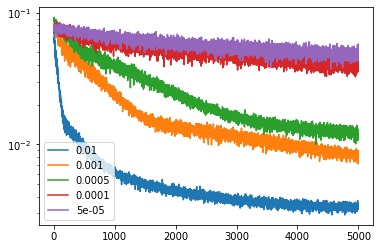

In [0]:
for n,exp in LR_HYPER.items():
    try:
        plt.semilogy(exp.losses,'-',label=n)
    except:
        print("Skipping ",n)
plt.legend()

In [0]:
for n,exp in LR_HYPER.items():
    try:
        exp.post()
        plt.figure()
        plt.title(n)
        seaborn.heatmap(exp.all_lambdas[-1], cmap='RdBu', center=0)
    except:
        print("Skipping ",n)

NameError: ignored